# 모듈 임포트
필요한 모듈들을 임포트 한다.

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# !gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
# !unzip -q instance-level-human-parsing.zip

# 학습할 데이터들을 불러오는 code cell
학습에 사용할 이미지들을 불러오고 이들을 텐서플로우 데이터셋 형식으로 만들어 학습할 때 사용하기 편하게 만든다.

In [3]:

IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

2023-06-12 15:02:52.676254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 15:02:52.697663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 15:02:52.697773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 15:02:52.719715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


# 베이스가 되는 레이어
DeepLabV3+에서 사용할 더 작은 단위의 레이어들의 묶음을 함수로 정의해서 층을 추가할 때 용이하게 한다.

## 1. convolution_block 함수
256개의 3x3xC 크기의 필터를 Atrous Convolution할 때의 rate는 1로 해서 적용하는 컨볼루션 층 하나와 그 후에 적용하는 BatchNormalization 층 하나를 묶어 함수 하나로 만들었다.

## 2. DilatedSpatialPyramidPooling 함수
ASPP를 한다. 이때 rate는 1, 6, 12, 18인 Atrous Convolution 층 4개와 AveragePooling을 하고 1x1xC Convolution을 한 후 UpSampling한 층 하나를 Concatenate해서 convolution_block의 입력으로 넣어 나온 레이어 묶음을 반환한다.


In [4]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

# DeeplabV3+ 메인 코드
모델의 입력은 함수에 매개변수로 전달될 image_size크기의 RGB, 총 3채널 이미지를 받는다.
DeeplabV3+는 ResNet50를 기본 backbone으로 사용하기 때문에 imagenet으로 학습된 ResNet50 모델을 불러오고 ResNet의 최종 출력을 ASPP를 수행하는 DilatedSpatialPyramidPooling 함수에 넣는다
그리고 ASPP를 한 결과물을 다시 Upsampling한다

ResNet의 중간에서 Skip Connection을 하기 위해 출력을 따로 빼둔다.
그 후 convolution_block을 거치고 위에서 Upsampling된 결과물과 Concatenate 하여 다시 convolution_block 두개를 거친다.
마지막으로 원본 이미지와 같은 크기로 Upsampling 해주고 총 20개의 클래스를 구분하기 때문에 20개의 1x1xC 크기의 필터를 갖는 컨볼루션 층을 한번 적용한 후 모델을 리턴한다

In [5]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 모델 학습 및 성능 평가
DeeplabV3+ 모델은 결국 분류 모델이기 때문에 SparseCategoricalCrossentropy loss함수를 사용하고 optimizer로는 Adam을 learning_rate는 0.001로 해서 사용하여 25에포크 동안 모델을 학습시킨다.
그 후 loss 곡선과 accuracy 곡선, validation loss 곡선과 validation accuracy 곡선을 그린다.

Epoch 1/25


2023-06-12 15:02:58.117721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2023-06-12 15:02:58.431759: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-12 15:02:59.240807: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-12 15:02:59.240840: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-12 15:02:59.240848: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

 42/250 [====>.........................] - ETA: 24s - loss: 1.5173 - accuracy: 0.5898

2023-06-12 15:03:05.104328: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 44/250 [====>.........................] - ETA: 24s - loss: 1.5012 - accuracy: 0.5912

2023-06-12 15:03:05.337565: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 49/250 [====>.........................] - ETA: 23s - loss: 1.4608 - accuracy: 0.5988

2023-06-12 15:03:05.954531: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-12 15:03:06.072400: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 94/250 [==========>...................] - ETA: 18s - loss: 1.3373 - accuracy: 0.6161

2023-06-12 15:03:11.190731: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


126/250 [==============>...............] - ETA: 14s - loss: 1.3026 - accuracy: 0.6165

2023-06-12 15:03:14.905279: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 36s 121ms/step - loss: 1.1638 - accuracy: 0.6489 - val_loss: 1.8568 - val_accuracy: 0.5753
Epoch 2/25
250/250 [==============================] - 28s 114ms/step - loss: 0.9300 - accuracy: 0.7040 - val_loss: 0.9913 - val_accuracy: 0.6924
Epoch 3/25
250/250 [==============================] - 28s 114ms/step - loss: 0.8230 - accuracy: 0.7354 - val_loss: 1.0444 - val_accuracy: 0.6771
Epoch 4/25
250/250 [==============================] - 28s 114ms/step - loss: 0.7750 - accuracy: 0.7502 - val_loss: 1.0788 - val_accuracy: 0.6746
Epoch 5/25
250/250 [==============================] - 28s 114ms/step - loss: 0.6991 - accuracy: 0.7757 - val_loss: 1.0169 - val_accuracy: 0.6918
Epoch 6/25
250/250 [==============================] - 32s 127ms/step - loss: 0.6580 - accuracy: 0.7880 - val_loss: 0.8649 - val_accuracy: 0.7328
Epoch 7/25
250/250 [==============================] - 32s 126ms/step - loss: 0.5917 - accuracy: 0.8109 - val_loss: 0.8585 - val_accuracy: 0.7

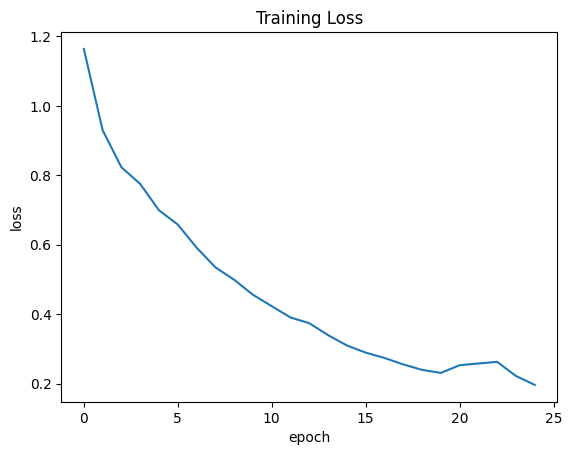

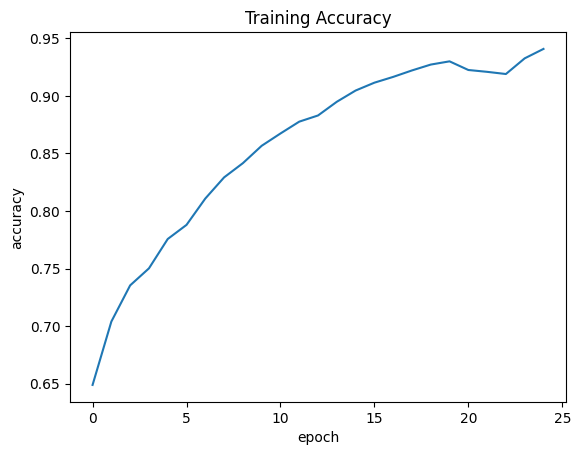

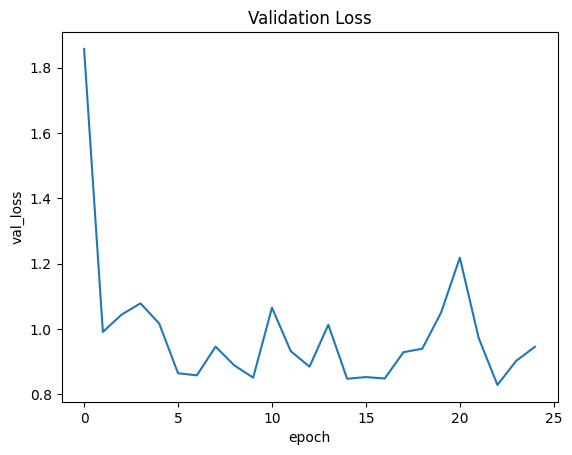

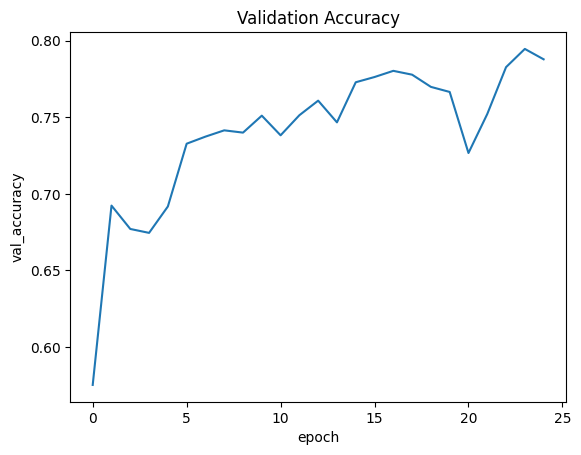

In [6]:
loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(num_classes,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_func,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

# 모델 성능 확인
학습이 완료된 모델이 Semantic Segentation을 제대로 할 수 있는지 확인하기 위해 몇개의 사진을 Semantic Segmentation 한 후 클래스 하나와 색깔 하나가 매핑된 컬러맵을 적용해 시각적으로 확인한다.

In [7]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, prediction_mask, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 1s 939ms/step


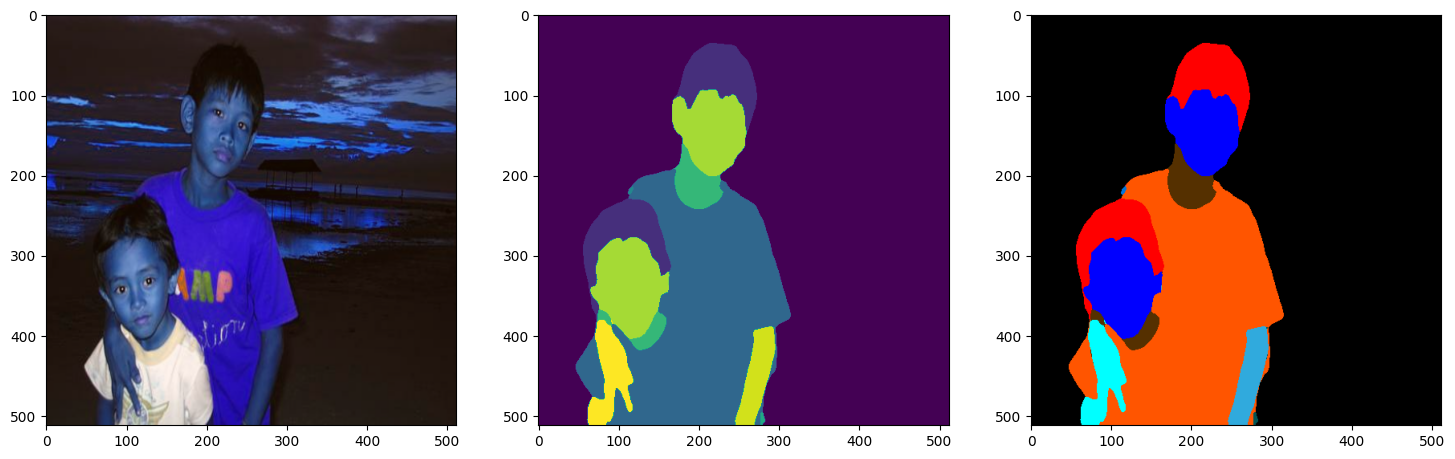

1/1 [==============================] - 0s 14ms/step


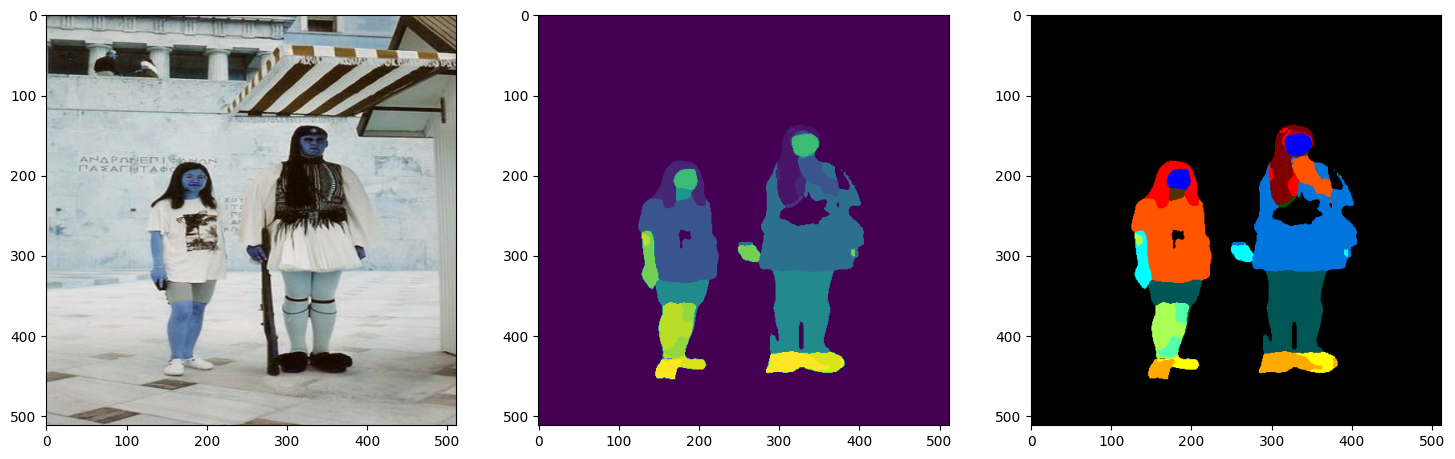

1/1 [==============================] - 0s 14ms/step


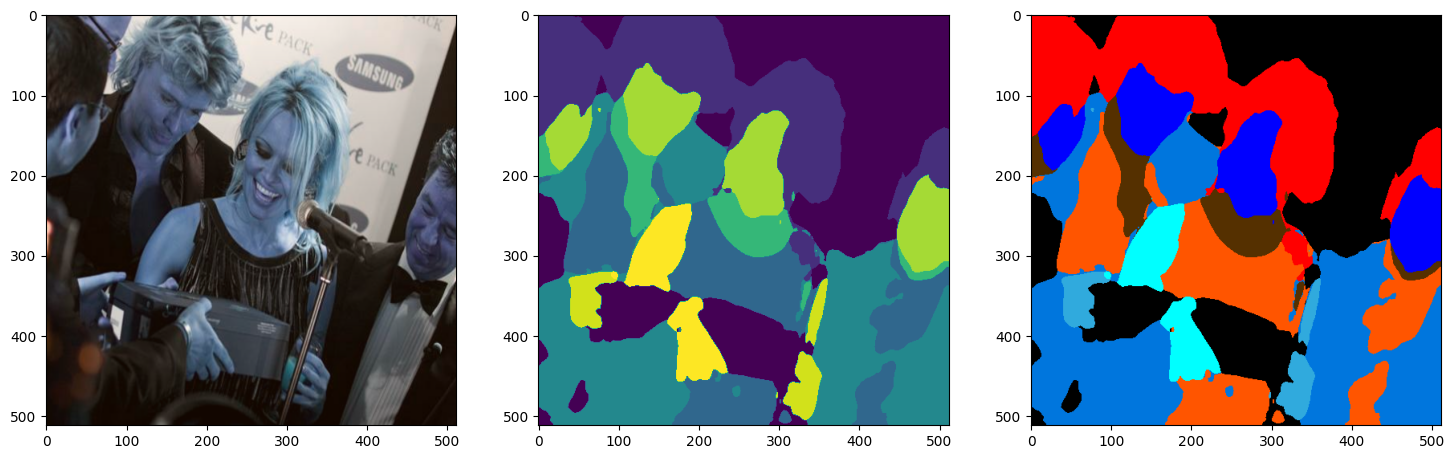

1/1 [==============================] - 0s 14ms/step


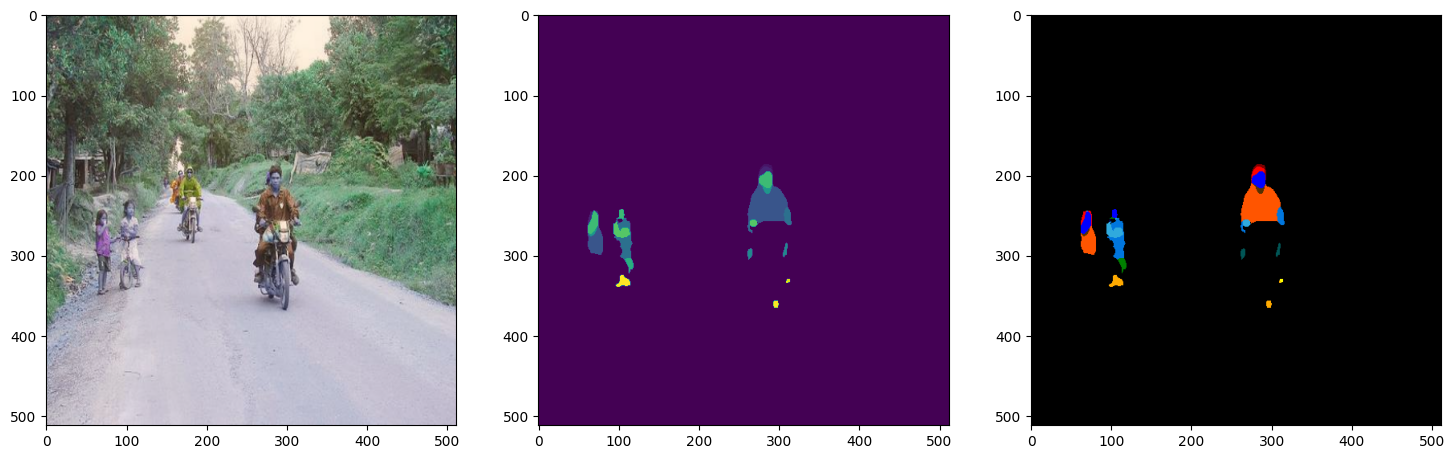

1/1 [==============================] - 0s 14ms/step


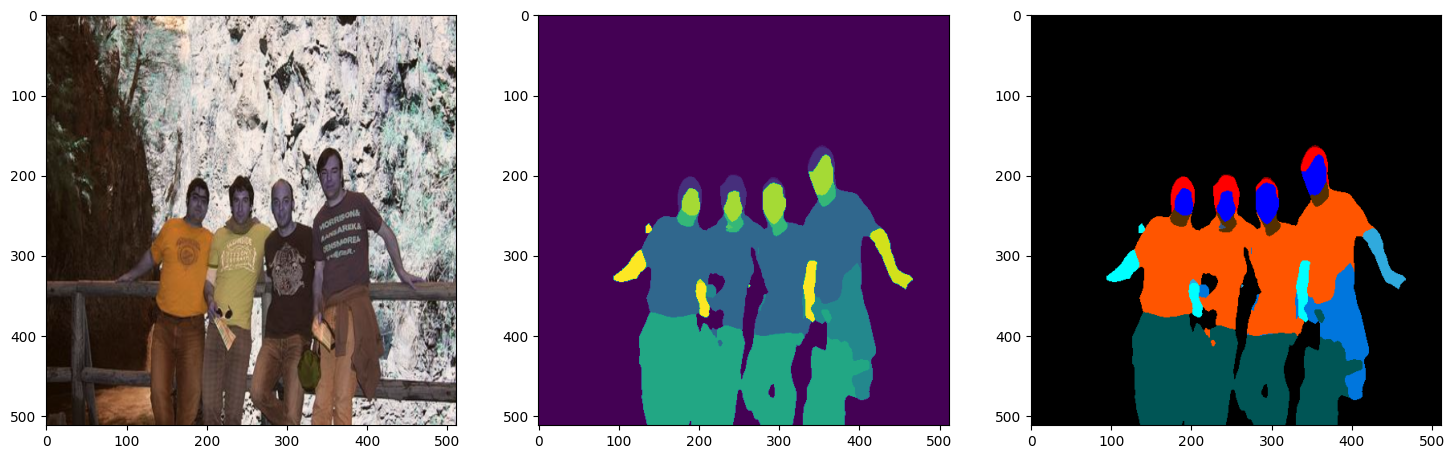

In [8]:
plot_predictions(train_images[7:12], colormap, model=model)

In [9]:
from tensorflow.keras.utils import plot_model

In [11]:
model.save("model.h5")